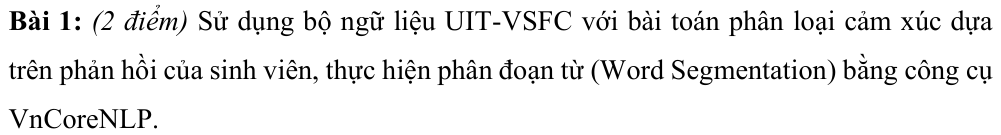

In [1]:
# Cài và tải mô hình VnCoreNLP
!pip install py_vncorenlp
!mkdir -p /content/vncorenlp

import py_vncorenlp
py_vncorenlp.download_model(save_dir='/content/vncorenlp')

# Khởi tạo mô hình phân tích từ
model = py_vncorenlp.VnCoreNLP(save_dir='/content/vncorenlp')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4304 sha256=97d5155d029a5f7dc3cac457617f191e073d8c6c7f3676f3d70bb717d1dec2c4
  Stored in directory: /root/.cache/pip/wheels/6d/2d/d6/158260bfd6820d144535857b80cc112bee5c3aa6d81b6dc049
Successfully built py_vncorenlp


In [2]:
# Tải và đọc dữ liệu UIT-VSFC
!pip install gdown
!gdown 1eJdEStCQBf3GtbOIQfIR2iS-Wb3nlfJX  # train
!gdown 1g4imdabNbswIu91K6zKFGalkjDBBqaQq  # dev
!gdown 1UWbzHFeUPu4AuofOEy0Fo0SFotVZHzUe  # test
!mv *.json ..

import json

with open("/content/UIT-VSFC-train.json", encoding='utf-8') as f:
    train_data = json.load(f)
with open("/content/UIT-VSFC-dev.json", encoding='utf-8') as f:
    dev_data = json.load(f)
with open("/content/UIT-VSFC-test.json", encoding='utf-8') as f:
    test_data = json.load(f)

print("Số lượng mẫu train:", len(train_data))
print("Số lượng mẫu dev:", len(dev_data))
print("Số lượng mẫu test:", len(test_data))

Downloading...
From: https://drive.google.com/uc?id=1eJdEStCQBf3GtbOIQfIR2iS-Wb3nlfJX
To: /content/vncorenlp/UIT-VSFC-train.json
100% 2.02M/2.02M [00:00<00:00, 95.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g4imdabNbswIu91K6zKFGalkjDBBqaQq
To: /content/vncorenlp/UIT-VSFC-test.json
100% 559k/559k [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UWbzHFeUPu4AuofOEy0Fo0SFotVZHzUe
To: /content/vncorenlp/UIT-VSFC-dev.json
100% 274k/274k [00:00<00:00, 88.7MB/s]
Số lượng mẫu train: 11426
Số lượng mẫu dev: 1583
Số lượng mẫu test: 3166


In [15]:
# Hàm phân đoạn từ cho toàn bộ câu
def segment_sentences(data, vncorenlp_model):
    segmented_sentences = []
    labels = []
    for item in data:
        sentence = item['sentence']
        label = item['sentiment']
        annotated = vncorenlp_model.annotate_text(sentence)[0]
        words = [tok['wordForm'].lower() for tok in annotated]
        segmented_sentences.append(words)
        labels.append(label)
    return segmented_sentences, labels

In [16]:
sample = train_data[0]['sentence']
print("Câu gốc:", sample)
tokens = model.annotate_text(sample)[0]
print("Phân đoạn từ:", ' | '.join([tok['wordForm'] for tok in tokens]))

Câu gốc: slide giáo trình đầy đủ .
Phân đoạn từ: slide | giáo_trình | đầy_đủ | .


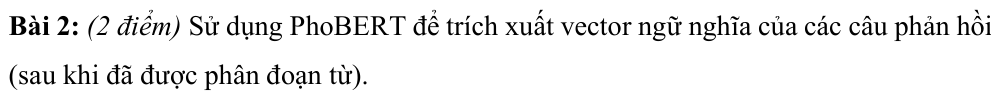

In [26]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained('vinai/phobert-base-v2')
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [31]:
ids = tokenizer.encode(train_data[0]['sentence'])

In [32]:
ids

[0, 48090, 4368, 1893, 545, 312, 5, 2]

In [33]:
input_ids = torch.tensor([ids])

In [34]:
input_ids.shape

torch.Size([1, 8])

In [35]:
output = phobert(input_ids)

In [36]:
features = output.last_hidden_state

In [37]:
features.shape

torch.Size([1, 8, 768])

In [40]:
# Hàm lấy vector CLS của câu
def get_phobert_vector(sentence):
    tokens = tokenizer.encode(sentence, return_tensors="pt", max_length=256, truncation=True)
    with torch.no_grad():
        output = phobert(tokens)
    # Lấy vector của token CLS (vị trí đầu tiên)
    cls_vector = output.last_hidden_state[0][0]  # shape: (768,)
    return cls_vector.numpy()

In [41]:
# Chuyển các câu đã phân đoạn thành string để dùng tokenizer
seg_train, y_train = segment_sentences(train_data, model)
seg_test, y_test = segment_sentences(test_data, model)

# Ghép lại thành chuỗi để dùng PhoBERT
train_sentences = [' '.join(s) for s in seg_train]
test_sentences = [' '.join(s) for s in seg_test]

# Vector hóa bằng PhoBERT
X_train = np.array([get_phobert_vector(sent) for sent in train_sentences])
X_test = np.array([get_phobert_vector(sent) for sent in test_sentences])

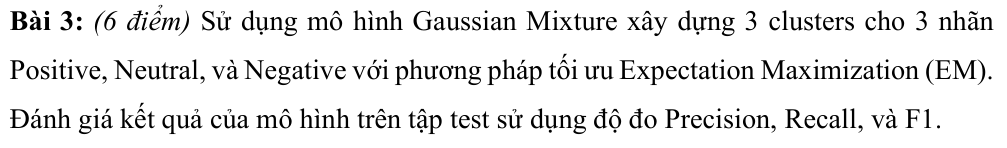

In [19]:
import numpy as np

In [20]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.components = eigenvectors[:, sorted_idx[:self.n_components]]

    def transform(self, X):
        return np.dot(X - self.mean, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [21]:
class GMM:
    def __init__(self, n_components, max_iter=100, comp_names=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.comp_names = comp_names or [f'comp_{i}' for i in range(n_components)]
        self.pi = [1 / n_components] * n_components

    def multivariate_normal(self, X, mean, cov):
        d = len(X)
        norm_const = (2 * np.pi) ** (-d/2) * np.linalg.det(cov) ** (-0.5)
        x_mu = X - mean
        inv_cov = np.linalg.inv(cov)
        exp_term = -0.5 * np.dot(np.dot(x_mu.T, inv_cov), x_mu)
        return norm_const * np.exp(exp_term)

    def fit(self, X):
        X = np.array(X)
        N, d = X.shape
        X_split = np.array_split(X, self.n_components)
        self.mean_vectors = [np.mean(chunk, axis=0) for chunk in X_split]
        self.covariance_matrices = [np.cov(chunk.T) + np.eye(d) * 1e-6 for chunk in X_split]

        for _ in range(self.max_iter):
            self.r = np.zeros((N, self.n_components))

            # E-step
            for n in range(N):
                denominator = sum(self.pi[j] * self.multivariate_normal(X[n], self.mean_vectors[j], self.covariance_matrices[j]) for j in range(self.n_components))
                for k in range(self.n_components):
                    numerator = self.pi[k] * self.multivariate_normal(X[n], self.mean_vectors[k], self.covariance_matrices[k])
                    self.r[n, k] = numerator / denominator

            # M-step
            N_k = np.sum(self.r, axis=0)
            self.mean_vectors = [np.sum(self.r[:, k][:, None] * X, axis=0) / N_k[k] for k in range(self.n_components)]
            self.covariance_matrices = [
                np.dot((self.r[:, k][:, None] * (X - self.mean_vectors[k])).T, X - self.mean_vectors[k]) / N_k[k] + np.eye(d) * 1e-6
                for k in range(self.n_components)
            ]
            self.pi = [N_k[k] / N for k in range(self.n_components)]

    def predict(self, X):
        X = np.array(X)
        results = []
        for x in X:
            probs = [
                self.pi[k] * self.multivariate_normal(x, self.mean_vectors[k], self.covariance_matrices[k])
                for k in range(self.n_components)
            ]
            results.append(self.comp_names[np.argmax(probs)])
        return results

In [22]:
def precision_recall_f1(y_true, y_pred, labels):
    result = {}
    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        result[label] = {
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-score": round(f1, 4)
        }
    return result

In [23]:
from collections import Counter

def map_clusters(y_true, y_cluster, label_list):
    from collections import Counter
    mapping = {}
    for c in set(y_cluster):
        label_counts = Counter([yt for yt, yc in zip(y_true, y_cluster) if yc == c])
        mapping[c] = label_counts.most_common(1)[0][0]
    return mapping  # ✅ trả về dict

In [42]:
# PCA giảm chiều
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# GMM huấn luyện
gmm = GMM(n_components=3)
gmm.fit(X_train_pca)

# Dự đoán nhãn test
y_pred_cluster = gmm.predict(X_test_pca)

# Tạo ánh xạ cluster → nhãn từ train
cluster_to_label = map_clusters(y_train, gmm.predict(X_train_pca), ['positive', 'neutral', 'negative'])

# Dự đoán nhãn gốc
y_pred = [cluster_to_label[c] for c in y_pred_cluster]

# Đánh giá
scores = precision_recall_f1(np.array(y_test), np.array(y_pred), ['positive', 'neutral', 'negative'])

for lbl in scores:
    print(f"{lbl.upper()}: {scores[lbl]}")

POSITIVE: {'Precision': np.float64(0.8081), 'Recall': np.float64(0.7522), 'F1-score': np.float64(0.7792)}
NEUTRAL: {'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1-score': np.float64(0.0)}
NEGATIVE: {'Precision': np.float64(0.7106), 'Recall': np.float64(0.8502), 'F1-score': np.float64(0.7742)}
